This notebook will demonstrate how to read the input data and visualize the predictions of a trained neural network model.

This example is best run with a GPU accelerator (**Runtime** -> **Change runtime type** -> **GPU**).

The interview problems are elaborated at the end of the notebook. For more background on these tasks, you may find our previous papers on animal pose estimation helpful [[1]](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6899221/)[[2]](https://www.biorxiv.org/content/10.1101/2020.08.31.276246v1).

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import cv2

Download the [input data](https://www.dropbox.com/s/b8974dstznzjzv4/test_clip.15s.mp4?dl=0) and the [trained TensorFlow/Keras model](https://www.dropbox.com/s/kuyqdopree4fh0r/best_model.h5?dl=0).

You can download them locally from the links above, or work directly in Colab using the code below.

The input data is a 1024 x 1024 pixel resolution grayscale MP4 video with 375 frames extracted from a movie of two interacting fruit flies.

The model is a convolutional neural network that takes as input a downsampled video frame and predicts a "heatmap" indicating the location of the center of the fruit flies. This model was trained using [SLEAP](https://sleap.ai) but it can be run without any dependencies other than TensorFlow 2.x.

Let's download the data to see how it works.

In [ ]:
tf.keras.utils.get_file("clip.mp4", "https://www.dropbox.com/s/b8974dstznzjzv4/test_clip.15s.mp4?dl=1", extract=False, cache_subdir="/content")
tf.keras.utils.get_file("keras_model.h5", "https://www.dropbox.com/s/kuyqdopree4fh0r/best_model.h5?dl=1", extract=False, cache_subdir="/content")

!ls -lah

5398528/5397088 [==============================] - 0s 0us/step
total 59M
drwxr-xr-x 1 root root 4.0K Sep 14 12:20 .
drwxr-xr-x 1 root root 4.0K Sep 14 12:07 ..
-rw-r--r-- 1 root root  54M Sep 14 12:20 clip.mp4
drwxr-xr-x 1 root root 4.0K Aug 31 16:13 .config
-rw-r--r-- 1 root root 5.2M Sep 14 12:20 keras_model.h5
drwxr-xr-x 1 root root 4.0K Aug 27 16:39 sample_data


The easiest way to load image data is to use OpenCV. Here we see how to check the frame count, seek to an arbitrary frame and decode the image data from the video container.

n_frames = 375
img.shape = (1024, 1024, 1)
img.dtype = uint8


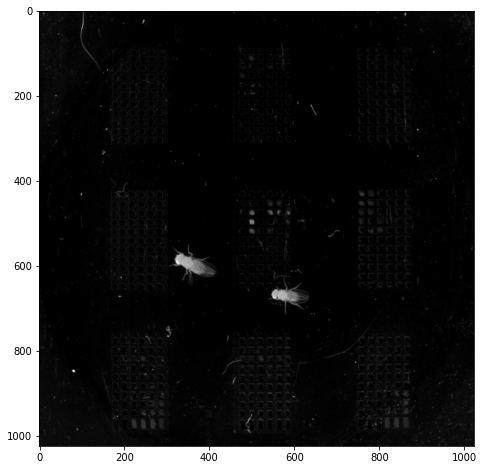

In [ ]:
# Open video clip for reading.
reader = cv2.VideoCapture("clip.mp4")

# Get the number of frames in the video.
n_frames = int(reader.get(cv2.CAP_PROP_FRAME_COUNT))
print(f"n_frames = {n_frames}")

# Seek to specific frame and decode the image data.
frame_idx = n_frames - 10
reader.set(cv2.CAP_PROP_POS_FRAMES, frame_idx)
status, img = reader.read()
img = img[:, :, :1]  # convert to grayscale
print(f"img.shape = {img.shape}")
print(f"img.dtype = {img.dtype}")

# Visualize image.
plt.figure(figsize=(8, 8))
plt.imshow(img.squeeze(), cmap="gray");

Next, let's load the trained model and use it to predict the heatmaps. We'll have to do some preprocessing on the image before providing it as input to the network.

Inputs: [<tf.Tensor 'input:0' shape=(None, 512, 512, 1) dtype=float32>]
Outputs: [<tf.Tensor 'CentroidConfmapsHead_0/BiasAdd:0' shape=(None, 256, 256, 1) dtype=float32>]
Y.shape = (1, 256, 256, 1)
Y.dtype = float32


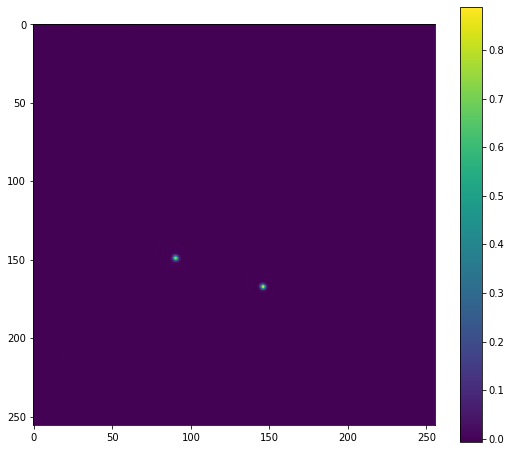

In [ ]:
# Load keras model.
model = tf.keras.models.load_model("keras_model.h5", compile=False)
print(f"Inputs: {model.inputs}")
print(f"Outputs: {model.outputs}")

# Preprocess the image for inference.
# Note that the input must be float32 in [0, 1] and of rank 4 with shape
# (batch_size, height, width, 1).
X = np.expand_dims(img, axis=0).astype("float32") / 255.
X = tf.image.resize(X, size=[512, 512])

# Predict on image.
Y = model.predict(X)
print(f"Y.shape = {Y.shape}")
print(f"Y.dtype = {Y.dtype}")

# Visualize output.
plt.figure(figsize=(9, 8))
plt.imshow(Y.squeeze())
plt.colorbar();

Though the shapes of the image and output heatmaps are different, if we rescale them we see that the peaks of the heatmap are roughly on top of the flies.

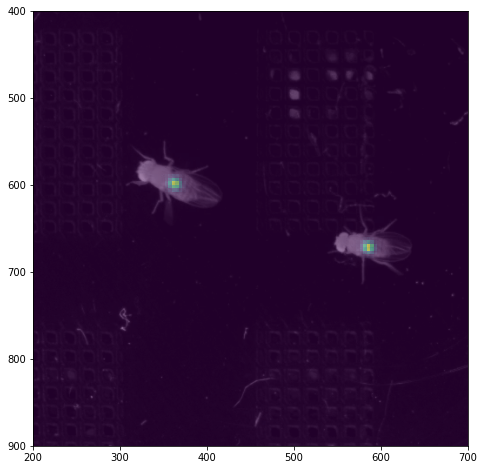

In [ ]:
plt.figure(figsize=(8, 8))
plt.imshow(img.squeeze(), cmap="gray")
plt.imshow(
    Y.squeeze(),
    extent=[
            -0.5,
            img.shape[1] - 0.5,
            img.shape[0] - 0.5,
            -0.5,
    ],  # (left, right, top, bottom),
    alpha=0.5
)
plt.xlim([200, 700])
plt.ylim([900, 400]);

As a technical challenge, we ask that you solve **one** of the tasks below.

We will be looking for correctness of the implementation, code documentation (full docstrings as well as inline comments), style (we recommend a linter), and creativity. All implementations must be in Python and runnable either in Colab or as a standalone script.


---


**Task A: Build a server that can interactively perform model inference.**

*Skills tested: TensorFlow, concurrent programming, interactive UI design.*

This should roughly accomplish the same functionality as above, but separated into a client and server running **in separate concurrent processes**.

The client will be responsible for loading image data and sending it to the server to request the model prediction results. The server will be responsible for loading the model, listening for requests, receiving the data, predicting the output heatmaps, and sending it back to the client.

If building this on Colab, the client can run in the notebook kernel, but should be able to be controlled interactively via a widget (similar to [this example](https://colab.research.google.com/github/talmo/sleap-mit-tutorial/blob/master/notebooks/Interactive_inference.ipynb#scrollTo=SuG7xlsb8HkZ)). You may look at the SLEAP source code for reference, but you may not use it as a dependency in your implementation.

The server should run in a separate [`multiprocessing.Process`](https://docs.python.org/3.6/library/multiprocessing.html#multiprocessing.Process) such that the data reading and model prediction are executed in parallel processes -- they may not share memory. The interprocess communication can be implemented however you prefer, but we recommend using [pyzmq](https://pyzmq.readthedocs.io/en/latest/) over TCP.

Once the client receives the result from the server, it should render the raw image overlaid with the predicted heatmap, as shown above.

*Implementation challenges (optional but will be viewed very favorably):*
- Additionally implement local peak finding and have the server return just the coordinates of the peaks rather than the full heatmap arrays.
- Implement this as a stand-alone script or module that performs the video seeking and all visualization in a [PySide2](https://wiki.qt.io/Qt_for_Python) desktop GUI instead of in a notebook environment.


---


**Task B: Implement a multi-object tracker to assign the predicted centroids to the correct animal over time.**

*Skills tested: Algorithm design, machine learning, performance optimization.*

This should perform the model prediction as outlined above and convert the heatmaps to `(x, y)` coordinates on the image using local peak finding. Since each peak is a point returned in potentially any order, you must assign each point to a unique "track" such that the detections assigned to the same track correspond to the same animal across frames. You may use any algorithm to do this, including using the image data if needed.

For this task, you may prototype with the video above, but you will be required to track a longer [8 fly video](https://www.dropbox.com/s/r6bounkedemplz2/many_flies.clip.mp4?dl=0). We provide the [ground truth coordinates and track assignments](https://www.dropbox.com/s/lmybbpem8t64y73/many_flies.clip.centroids.h5?dl=0) so you can check your solution. See the cell below for an example on how to read this data and the ground truth.

Your implementation **must** use the model above for predicting the coordinates. The predictions from the model will not match the coordinates in the ground truth exactly, some detections may be missed on some frames, and duplicated in others. Your algorithm must be able to handle these cases and avoid identity switches between animals. You do not need to get 100% accuracy, but you must report the fraction of frames in which the tracks are correctly assigned correctly. You may use [py-motmetrics](https://github.com/cheind/py-motmetrics) for computing the accuracy, but not for solving the tracking problem.

Your implementation must be optimized to run fast enough such that the tracking takes less time than the TensorFlow model prediction alone. Report the runtime of each component.

You may look at the SLEAP source code for reference, but you may not use it as a dependency in your implementation.

*Implementation challenges (optional but will be viewed very favorably):*
- Implement the peak finding in TensorFlow on the GPU such that the heatmap tensor does not have to be copied back to the CPU when predicting on the images.
- Implement your tracking algorithm in parallel or on the GPU.

The code below will demonstrate the format of the data you are provided.

In [ ]:
# Download data for Task B.
tf.keras.utils.get_file("long_clip.mp4", "https://www.dropbox.com/s/r6bounkedemplz2/many_flies.clip.mp4?dl=1", extract=False, cache_subdir="/content")
tf.keras.utils.get_file("ground_truth.h5", "https://www.dropbox.com/s/lmybbpem8t64y73/many_flies.clip.centroids.h5?dl=1", extract=False, cache_subdir="/content")

!ls -lah

1335296/1332191 [==============================] - 0s 0us/step
total 422M
drwxr-xr-x 1 root root 4.0K Sep 14 12:21 .
drwxr-xr-x 1 root root 4.0K Sep 14 12:07 ..
-rw-r--r-- 1 root root  54M Sep 14 12:20 clip.mp4
drwxr-xr-x 1 root root 4.0K Aug 31 16:13 .config
-rw-r--r-- 1 root root 1.3M Sep 14 12:21 ground_truth.h5
-rw-r--r-- 1 root root 5.2M Sep 14 12:20 keras_model.h5
-rw-r--r-- 1 root root 363M Sep 14 12:21 long_clip.mp4
drwxr-xr-x 1 root root 4.0K Aug 27 16:39 sample_data


In [ ]:
# Open video clip for reading.
reader = cv2.VideoCapture("long_clip.mp4")

# Get the number of frames in the video.
n_frames = int(reader.get(cv2.CAP_PROP_FRAME_COUNT))
print(f"n_frames = {n_frames}")

n_frames = 13000


In [ ]:
import h5py

# Inspect the HDF5 file with the ground truth.
with h5py.File("ground_truth.h5", "r") as f:
  for key, ds in f.items():
    print(f"Dataset: {key} -> shape = {ds.shape}, dtype = {ds.dtype}")

Dataset: track0 -> shape = (13000, 2), dtype = float64
Dataset: track1 -> shape = (13000, 2), dtype = float64
Dataset: track2 -> shape = (13000, 2), dtype = float64
Dataset: track3 -> shape = (13000, 2), dtype = float64
Dataset: track4 -> shape = (13000, 2), dtype = float64
Dataset: track5 -> shape = (13000, 2), dtype = float64
Dataset: track6 -> shape = (13000, 2), dtype = float64
Dataset: track7 -> shape = (13000, 2), dtype = float64


The datasets in the ground truth file correspond to the true (x, y) coordinates of each animal. Over time, they form contiguous trajectories as visualized below.

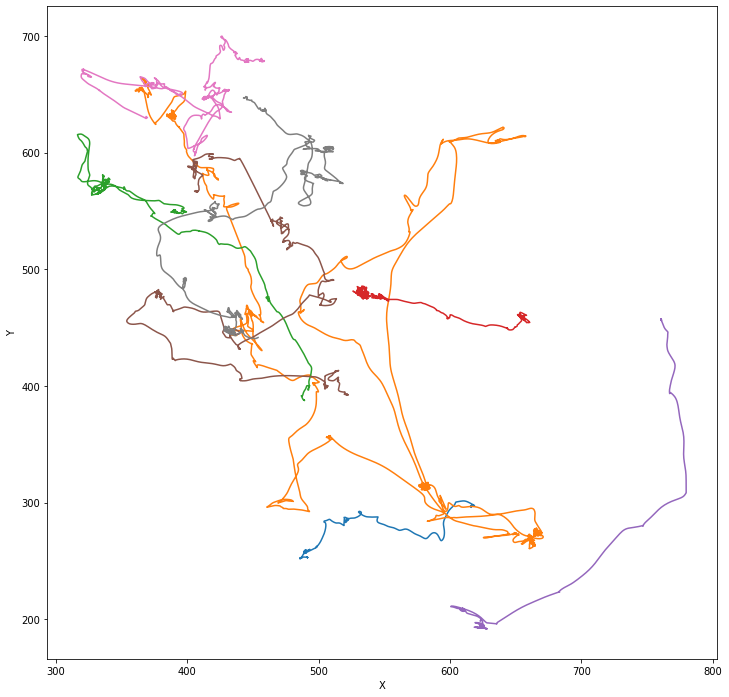

In [ ]:
# Visualize the entire tracks for all flies.
plt.figure(figsize=(12, 12))
with h5py.File("ground_truth.h5", "r") as f:
  for track in f.values():
    plt.plot(track[:, 0], track[:, 1], "-")
plt.xlabel("X")
plt.ylabel("Y");

If we plot the coordinates on several frames over time we see that the same colors are assigned to the points belonging to the same animals.

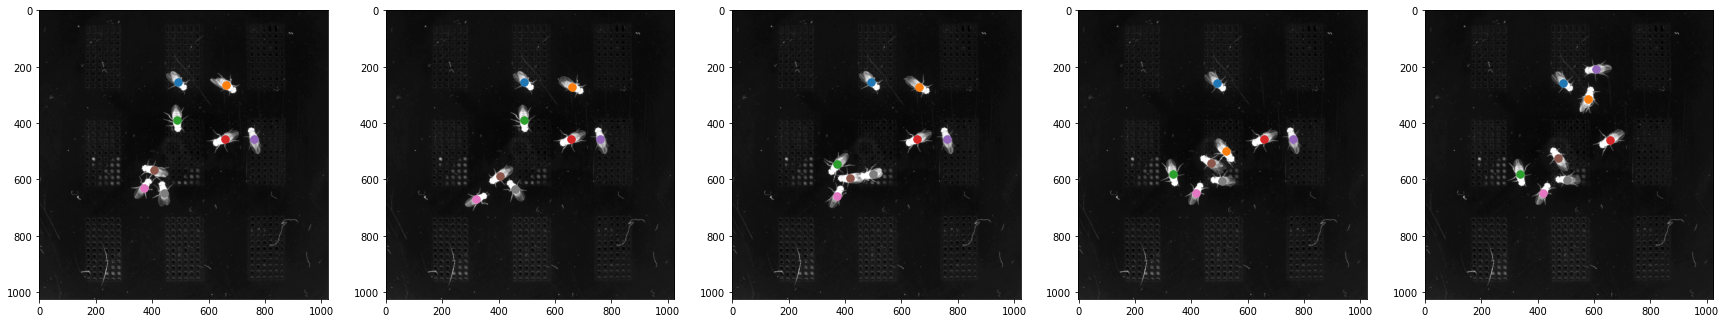

In [ ]:
# Visualize 6 different frames with ground truth points colored by track.
plt.figure(figsize=(6 * 5, 6))

for i, frame_idx in enumerate([0, 1000, 2000, 3000, 4000]):

  # Seek to specific frame and decode the image data.
  reader.set(cv2.CAP_PROP_POS_FRAMES, frame_idx)
  status, img = reader.read()

  # Load points for the current frame.
  with h5py.File("ground_truth.h5", "r") as f:
    pts = [track[frame_idx] for track in f.values()]

  # Plot the image and points.
  plt.subplot(1, 5, i + 1)
  plt.imshow(img.squeeze(), cmap="gray")
  for (x, y) in pts:
    plt.plot(x, y, ".", ms=15)

Move the slider below to visualize the ground truth track assignments interactively frame-by-frame.

In [ ]:
%matplotlib inline
from ipywidgets import interactive

def plot_frame(frame_idx=0):
  plt.figure(figsize=(8, 8))

  # Seek to specific frame and decode the image data.
  reader.set(cv2.CAP_PROP_POS_FRAMES, frame_idx)
  status, img = reader.read()

  # Load points for the current frame.
  with h5py.File("ground_truth.h5", "r") as f:
    pts = [track[frame_idx] for track in f.values()]

  # Plot the image and points.
  plt.imshow(img.squeeze(), cmap="gray")
  for (x, y) in pts:
    plt.plot(x, y, ".", ms=15)

interactive_plot = interactive(plot_frame, frame_idx=(0, n_frames - 1, 1))
output = interactive_plot.children[-1]
output.layout.height = "600px"
interactive_plot

interactive(children=(IntSlider(value=0, description='frame_idx', max=12999), Output(layout=Layout(height='600…